# Library Imports

In [30]:
# Data and DataFrame
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# EDA
import scipy.stats as stats
from scipy.stats import pointbiserialr, spearmanr, chi2_contingency

# Modelling - Decision Tree Classifier
from tqdm import tqdm # use the standard console-based progress bar
tqdm.pandas()
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.tree import plot_tree

# Modelling - Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

# Hyperparameter Optimisation and Tracking
import optuna
from optuna.samplers import TPESampler
import neptune
import neptune.integrations.optuna as npt_utils


# Data Wrangling

In [31]:
data = pd.read_csv('data/Predict Hair Fall.csv')

In [32]:
data.shape

(999, 13)

In [33]:
data.head()

,Id,Genetics,Hormonal Changes,Medical Conditions,Medications & Treatments,Nutritional Deficiencies,Stress,Age,Poor Hair Care Habits,Environmental Factors,Smoking,Weight Loss,Hair Loss
0,133992,Yes,No,No Data,No Data,Magnesium deficiency,Moderate,19,Yes,Yes,No,No,0
1,148393,No,No,Eczema,Antibiotics,Magnesium deficiency,High,43,Yes,Yes,No,No,0
2,155074,No,No,Dermatosis,Antifungal Cream,Protein deficiency,Moderate,26,Yes,Yes,No,Yes,0
3,118261,Yes,Yes,Ringworm,Antibiotics,Biotin Deficiency,Moderate,46,Yes,Yes,No,No,0
4,111915,No,No,Psoriasis,Accutane,Iron deficiency,Moderate,30,No,Yes,Yes,No,1


In [34]:
# Checking data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Id                         999 non-null    int64 
 1   Genetics                   999 non-null    object
 2   Hormonal Changes           999 non-null    object
 3   Medical Conditions         999 non-null    object
 4   Medications & Treatments   999 non-null    object
 5   Nutritional Deficiencies   999 non-null    object
 6   Stress                     999 non-null    object
 7   Age                        999 non-null    int64 
 8   Poor Hair Care Habits      999 non-null    object
 9   Environmental Factors      999 non-null    object
 10  Smoking                    999 non-null    object
 11  Weight Loss                999 non-null    object
 12  Hair Loss                  999 non-null    int64 
dtypes: int64(3), object(10)
memory usage: 101.6+ KB


In [35]:
data.columns = data.columns.str.strip()

In [36]:
# Check for any duplicates in Id column which should be unique.
data.duplicated('Id').sum()

4

In [37]:
# Display all duplicate rows, arranged by Id
data[data['Id'].duplicated(keep=False)].sort_values('Id')

,Id,Genetics,Hormonal Changes,Medical Conditions,Medications & Treatments,Nutritional Deficiencies,Stress,Age,Poor Hair Care Habits,Environmental Factors,Smoking,Weight Loss,Hair Loss
388,110171,Yes,No,Thyroid Problems,Antifungal Cream,Selenium deficiency,Low,25,Yes,No,Yes,Yes,0
408,110171,No,No,Psoriasis,Immunomodulators,Vitamin E deficiency,Low,41,Yes,No,No,Yes,0
237,157627,Yes,No,Dermatosis,Rogaine,Protein deficiency,Moderate,47,Yes,No,Yes,Yes,1
600,157627,No,No,Thyroid Problems,Accutane,Protein deficiency,Moderate,44,Yes,Yes,Yes,Yes,0
118,172639,Yes,Yes,Androgenetic Alopecia,Heart Medication,Iron deficiency,Moderate,29,Yes,No,Yes,No,1
866,172639,Yes,Yes,No Data,Accutane,Vitamin A Deficiency,Low,47,Yes,No,No,Yes,0
669,186979,No,No,Seborrheic Dermatitis,Blood Pressure Medication,Vitamin E deficiency,Moderate,41,No,No,No,No,1
956,186979,Yes,Yes,Seborrheic Dermatitis,Chemotherapy,No Data,Moderate,21,No,No,Yes,No,1


Given that the ages are different for the duplicated rows, it can be assumed that each is a record of a different study subject and it is likely that there was an issue in ID generation when recording the data, hence the conflicts.  
Will drop Id column, and use the index as identifier.

In [38]:
data.drop('Id', axis=1, inplace=True)

In [39]:
# Using row index as identifier for each record.
data.reset_index()

,index,Genetics,Hormonal Changes,Medical Conditions,Medications & Treatments,Nutritional Deficiencies,Stress,Age,Poor Hair Care Habits,Environmental Factors,Smoking,Weight Loss,Hair Loss
0,0,Yes,No,No Data,No Data,Magnesium deficiency,Moderate,19,Yes,Yes,No,No,0
1,1,No,No,Eczema,Antibiotics,Magnesium deficiency,High,43,Yes,Yes,No,No,0
2,2,No,No,Dermatosis,Antifungal Cream,Protein deficiency,Moderate,26,Yes,Yes,No,Yes,0
3,3,Yes,Yes,Ringworm,Antibiotics,Biotin Deficiency,Moderate,46,Yes,Yes,No,No,0
4,4,No,No,Psoriasis,Accutane,Iron deficiency,Moderate,30,No,Yes,Yes,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,994,Yes,No,Seborrheic Dermatitis,Rogaine,Vitamin A Deficiency,Low,33,Yes,Yes,Yes,Yes,1
995,995,Yes,Yes,No Data,Accutane,Protein deficiency,Low,47,No,No,No,Yes,0
996,996,No,Yes,Androgenetic Alopecia,Antidepressants,Protein deficiency,Moderate,20,Yes,No,Yes,Yes,1
997,997,No,Yes,Dermatitis,Immunomodulators,Biotin Deficiency,Moderate,32,Yes,Yes,Yes,Yes,1


In [40]:
# Convert Stress Level to ordinal (0=Low, 1=Moderate, 2=High)
stress_mapping = {'Low': 0, 'Moderate': 1, 'High': 2}
data['Stress'] = data['Stress'].map(stress_mapping)

From initial Tableau evaluation, there were multiple data points containing 'No Data' in columns: Medical Conditions, Medications & Treatments, Nutritional Deficiencies.
Keeping them as 'No Data' as Label Encoder will not handle nulls.

In [41]:
# for col in data.columns:
#     if data[col].dtype.name == 'object':
#         data.loc[data[col] == 'No Data', col] = np.nan

In [42]:
# Change all 'Yes/No' to boolean data type and other 'object' data type columns to 'category'
for col in data.select_dtypes('object').columns:
    if data[col].nunique() == 2:
        data[col] = data[col].map({"Yes": 1, "No": 0})
        data[col] = data[col].astype('boolean')
    else:
        data[col] = data[col].astype('category')

In [43]:
# Convert target column from integer to Boolean type.
data['Hair Loss'] = data['Hair Loss'].astype('boolean')

In [44]:
data.head()

,Genetics,Hormonal Changes,Medical Conditions,Medications & Treatments,Nutritional Deficiencies,Stress,Age,Poor Hair Care Habits,Environmental Factors,Smoking,Weight Loss,Hair Loss
0,True,False,No Data,No Data,Magnesium deficiency,1,19,True,True,False,False,False
1,False,False,Eczema,Antibiotics,Magnesium deficiency,2,43,True,True,False,False,False
2,False,False,Dermatosis,Antifungal Cream,Protein deficiency,1,26,True,True,False,True,False
3,True,True,Ringworm,Antibiotics,Biotin Deficiency,1,46,True,True,False,False,False
4,False,False,Psoriasis,Accutane,Iron deficiency,1,30,False,True,True,False,True


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Genetics                  999 non-null    boolean 
 1   Hormonal Changes          999 non-null    boolean 
 2   Medical Conditions        999 non-null    category
 3   Medications & Treatments  999 non-null    category
 4   Nutritional Deficiencies  999 non-null    category
 5   Stress                    999 non-null    int64   
 6   Age                       999 non-null    int64   
 7   Poor Hair Care Habits     999 non-null    boolean 
 8   Environmental Factors     999 non-null    boolean 
 9   Smoking                   999 non-null    boolean 
 10  Weight Loss               999 non-null    boolean 
 11  Hair Loss                 999 non-null    boolean 
dtypes: boolean(7), category(3), int64(2)
memory usage: 33.5 KB


# Univariate Analysis

In [46]:
data.describe()

,Stress,Age
count,999.000000,999.000000
mean,0.993994,34.188188
std,0.805768,9.377980
min,0.000000,18.000000
25%,0.000000,26.000000
50%,1.000000,34.000000
75%,2.000000,42.000000
max,2.000000,50.000000


In [47]:
data.describe(include = ['boolean','category'])

,Genetics,Hormonal Changes,Medical Conditions,Medications & Treatments,Nutritional Deficiencies,Poor Hair Care Habits,Environmental Factors,Smoking,Weight Loss,Hair Loss
count,999,999,999,999,999,999,999,999,999,999
unique,2,2,11,11,11,2,2,2,2,2
top,True,True,No Data,Rogaine,Zinc Deficiency,False,True,True,False,False
freq,522,509,110,116,108,507,508,519,527,502


In [53]:
print(f"{data['Hair Loss'].sum()} out of {data.shape[0]} records are cases of hair loss being present.")

497 out of 999 records are cases of hair loss being present.


In [ ]:
data.to_csv('data/cleaned_data.csv')

# Bivariate & Multivariate Analysis

In [ ]:
data

,Genetics,Hormonal Changes,Medical Conditions,Medications & Treatments,Nutritional Deficiencies,Stress,Age,Poor Hair Care Habits,Environmental Factors,Smoking,Weight Loss,Hair Loss
0,True,False,No Data,No Data,Magnesium deficiency,1,19,True,True,False,False,False
1,False,False,Eczema,Antibiotics,Magnesium deficiency,2,43,True,True,False,False,False
2,False,False,Dermatosis,Antifungal Cream,Protein deficiency,1,26,True,True,False,True,False
3,True,True,Ringworm,Antibiotics,Biotin Deficiency,1,46,True,True,False,False,False
4,False,False,Psoriasis,Accutane,Iron deficiency,1,30,False,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
994,True,False,Seborrheic Dermatitis,Rogaine,Vitamin A Deficiency,0,33,True,True,True,True,True
995,True,True,No Data,Accutane,Protein deficiency,0,47,False,False,False,True,False
996,False,True,Androgenetic Alopecia,Antidepressants,Protein deficiency,1,20,True,False,True,True,True
997,False,True,Dermatitis,Immunomodulators,Biotin Deficiency,1,32,True,True,True,True,True


In [ ]:
# Grouping the columns

# List of binary columns (excluding Hair Loss)
binary_cols = data.drop('Hair Loss', axis = 1).select_dtypes(include = bool).columns

# Nominal column
nominal_col = 'Age'

# Ordinal column
ordinal_col = 'Stress'

# Target
target = 'Hair Loss'

In [ ]:
# Function to compute Phi coefficient, a statistical measure derived from the Chi-Square statistic that quantifies the association between two binary categorical variables.
def phi_coefficient(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / n)

# 1. Binary vs Binary correlations
binary_corr = pd.DataFrame(index=binary_cols, columns=binary_cols)
for col1 in binary_cols:
    for col2 in binary_cols:
        if col1 == col2:
            binary_corr.loc[col1, col2] = 1.0
        else:
            confusion_matrix = pd.crosstab(data[col1], data[col2])
            binary_corr.loc[col1, col2] = phi_coefficient(confusion_matrix)

# 2. Binary vs Nominal (Age)
age_corr = {}
for col in binary_cols:
    r, p = pointbiserialr(data[col], data[nominal_col])
    age_corr[col] = r

# 3. Binary vs Ordinal (Stress)
stress_corr = {}
for col in binary_cols:
    r, p = spearmanr(data[col], data[ordinal_col])
    stress_corr[col] = r

# 4. Nominal vs Ordinal (Age vs Stress)
# Using Cramér's V
confusion_matrix = pd.crosstab(data[nominal_col], data[ordinal_col])
chi2 = chi2_contingency(confusion_matrix)[0]
n = confusion_matrix.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

# 5. All variables vs Hair Loss (target)
target_corr = {}

# Binary vs Binary (Phi)
for col in binary_cols:
    confusion_matrix = pd.crosstab(data[col], data[target])
    target_corr[col] = phi_coefficient(confusion_matrix)

# Age vs Hair Loss (Point-Biserial)
r, p = pointbiserialr(data[nominal_col], data[target])
target_corr['Age'] = r

# Stress vs Hair Loss (Rank-Biserial)
r, p = spearmanr(data[ordinal_col], data[target])
target_corr['Stress'] = r

# Convert to DataFrames for better visualization
age_corr_data = pd.DataFrame.from_dict(age_corr, orient='index', columns=['Age_Correlation'])
stress_corr_data = pd.DataFrame.from_dict(stress_corr, orient='index', columns=['Stress_Correlation'])
target_corr_data = pd.DataFrame.from_dict(target_corr, orient='index', columns=['Hair_Loss_Correlation'])

print("Binary vs Binary Correlations:")
print(binary_corr)

print("\nBinary vs Age Correlations:")
print(age_corr_data)

print("\nBinary vs Stress Correlations:")
print(stress_corr_data)

print(f"\nAge vs Stress Correlation (Cramér's V): {cramers_v:.3f}")

print("\nAll Variables vs Hair Loss Correlations:")
print(target_corr_data)

Binary vs Binary Correlations:
                       Genetics Hormonal Changes Poor Hair Care Habits  \
Genetics                    1.0         0.005869              0.010346   
Hormonal Changes       0.005869              1.0              0.048778   
Poor Hair Care Habits  0.010346         0.048778                   1.0   
Environmental Factors  0.028295         0.049389              0.061332   
Smoking                0.030842         0.020298              0.003592   
Weight Loss            0.004539         0.052094                   0.0   

                      Environmental Factors   Smoking Weight Loss  
Genetics                           0.028295  0.030842    0.004539  
Hormonal Changes                   0.049389  0.020298    0.052094  
Poor Hair Care Habits              0.061332  0.003592         0.0  
Environmental Factors                   1.0  0.010356     0.00207  
Smoking                            0.010356       1.0         0.0  
Weight Loss                         0.0020

# Neptune for tracking

In [ ]:
# Initialize Neptune
run = neptune.init_run(
    project="Capstone-HairlossAnalysis/Hair-Loss-Classifier",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2NzVhYzE1Ni02NzljLTQ2YWQtODg0Mi0yY2ExYTZlOTA0MDUifQ==",
    tags=["optuna", "optimization", "RFClassifier", "DTClassifier"],
    mode="sync"  # Add this line
)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/Capstone-HairlossAnalysis/Hair-Loss-Classifier/e/HAIRLOSSRF-16


# Modelling with Optimisation using Optuna

Decision Tree Classifier and Random Forest Classifier

Due to poor correlation of features to target column, I'll use decision tree classification method.

While LabelEncoder works better for ordinal categories, trees are not affected by the ordinal nature. Due to 3 columns containing a long category list, it is more space efficient to adopt LabelEncoder than One Hot Encoding.

In [ ]:
# 'Hair Loss' being target variable
X = data.drop(columns=['Hair Loss'], axis = 1)  # Remove the target variable
y = data['Hair Loss']

# Identify categorical columns (modify as needed)
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Handle the categorical columns before training -> Apply LabelEncoder to each categorical column
label_encoders = {}
le = LabelEncoder()
for col in categorical_cols:
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le  # Store encoders for inverse transform later if needed

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [ ]:
# Define multiple scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'recall': metrics.make_scorer(metrics.recall_score, average='macro')  # Macro-average for multi-class
}

# 1. Define an objective function to be maximized.
def objective(trial):
    # Choose model to optimize
    classifier_name = trial.suggest_categorical("classifier", ["DecisionTree", "RandomForest"])
    
    if classifier_name == "DecisionTree":
        params = {
            "criterion": trial.suggest_categorical("dt_criterion", ["gini", "entropy"]),
            "max_depth": trial.suggest_int("dt_max_depth", 2, 32),
            "min_samples_split": trial.suggest_float("dt_min_samples_split", 0.01, 1.0),
            "min_samples_leaf": trial.suggest_float("dt_min_samples_leaf", 0.01, 0.5),
            "max_features": trial.suggest_categorical("dt_max_features", ["sqrt", "log2", None])
        }
        model = DecisionTreeClassifier(**params)
    else:
        params = {
            "n_estimators": trial.suggest_int("rf_n_estimators", 50, 500),
            "max_depth": trial.suggest_int("rf_max_depth", 2, 32),
            "min_samples_split": trial.suggest_float("rf_min_samples_split", 0.01, 1.0),
            "min_samples_leaf": trial.suggest_float("rf_min_samples_leaf", 0.01, 0.5),
            "max_features": trial.suggest_categorical("rf_max_features", ["sqrt", "log2"]),
            "bootstrap": trial.suggest_categorical("rf_bootstrap", [True, False])
        }
        model = RandomForestClassifier(**params)

    # Use cross_validate instead of cross_val_score for multiple metrics
    scores = cross_validate(model, X_train, y_train, cv=5, n_jobs=-1, scoring=scoring)
    
    # Store accuracy in user attributes (to track it)
    trial.set_user_attr("accuracy", np.mean(scores['test_accuracy']))
    
    # Return recall (since we want to optimize recall)
    return np.mean(scores['test_recall'])  # Optimize recall but track accuracy

if __name__ == "__main__":
    # Create study with Bayesian optimization
    study = optuna.create_study(
        direction="maximize",
        sampler=TPESampler(seed=42)
    )
    
    # Run optimization
    study.optimize(objective, n_trials=100)
    
    # Print results
    print("\nBest trial:")
    print(f"  Recall (optimized): {study.best_value:.4f}")
    print(f"  Accuracy (tracked): {study.best_trial.user_attrs['accuracy']:.4f}")
    print(f"  Classifier: {study.best_params['classifier']}")


    run["train/recall"].append(study.best_value)
    run["train/accuracy"].append(study.best_trial.user_attrs['accuracy'])
    
    # Train final model with all data
    if study.best_params['classifier'] == "DecisionTree":
        dt_params = {k.replace('dt_', ''): v for k,v in study.best_params.items() if k.startswith('dt_')}
        best_model = DecisionTreeClassifier(**dt_params)
        run["train/parameters"].append(dt_params)
    else:
        rf_params = {k.replace('rf_', ''): v for k,v in study.best_params.items() if k.startswith('rf_')}
        best_model = RandomForestClassifier(**rf_params)
        run["train/parameters"].append(rf_params)
    
    
    run["train/model"].append(study.best_params['classifier'])
        
    best_model.fit(X_train, y_train)
    print("\nBest model trained on full data:", best_model)

[I 2025-04-04 16:00:45,102] A new study created in memory with name: no-name-b22ef98d-3b0f-4119-8517-cc0037b32316
[I 2025-04-04 16:00:45,481] Trial 0 finished with value: 0.4982622445852439 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 380, 'rf_max_depth': 20, 'rf_min_samples_split': 0.16445845403801215, 'rf_min_samples_leaf': 0.08643731496473929, 'rf_max_features': 'log2', 'rf_bootstrap': False}. Best is trial 0 with value: 0.4982622445852439.
[I 2025-04-04 16:00:45,996] Trial 1 finished with value: 0.5229549674394663 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 425, 'rf_max_depth': 8, 'rf_min_samples_split': 0.19000671753502962, 'rf_min_samples_leaf': 0.09986820982818256, 'rf_max_features': 'log2', 'rf_bootstrap': True}. Best is trial 1 with value: 0.5229549674394663.
[I 2025-04-04 16:00:46,021] Trial 2 finished with value: 0.5064253182854481 and parameters: {'classifier': 'DecisionTree', 'dt_criterion': 'entropy', 'dt_max_depth': 16, 'dt_min_


Best trial:
  Recall (optimized): 0.5476
  Accuracy (tracked): 0.5501
  Classifier: RandomForest

Best model trained on full data: RandomForestClassifier(bootstrap=False, max_depth=22,
                       min_samples_leaf=0.326077043904203,
                       min_samples_split=0.37308658916071785, n_estimators=404)


In [ ]:
run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/Capstone-HairlossAnalysis/Hair-Loss-Classifier/e/HAIRLOSSRF-16/metadata


                     Feature  Importance
2         Medical Conditions    0.272277
10               Weight Loss    0.188119
6                        Age    0.175743
9                    Smoking    0.150990
0                   Genetics    0.094059
3   Medications & Treatments    0.061881
4   Nutritional Deficiencies    0.034653
8      Environmental Factors    0.012376
1           Hormonal Changes    0.009901
5                     Stress    0.000000
7      Poor Hair Care Habits    0.000000


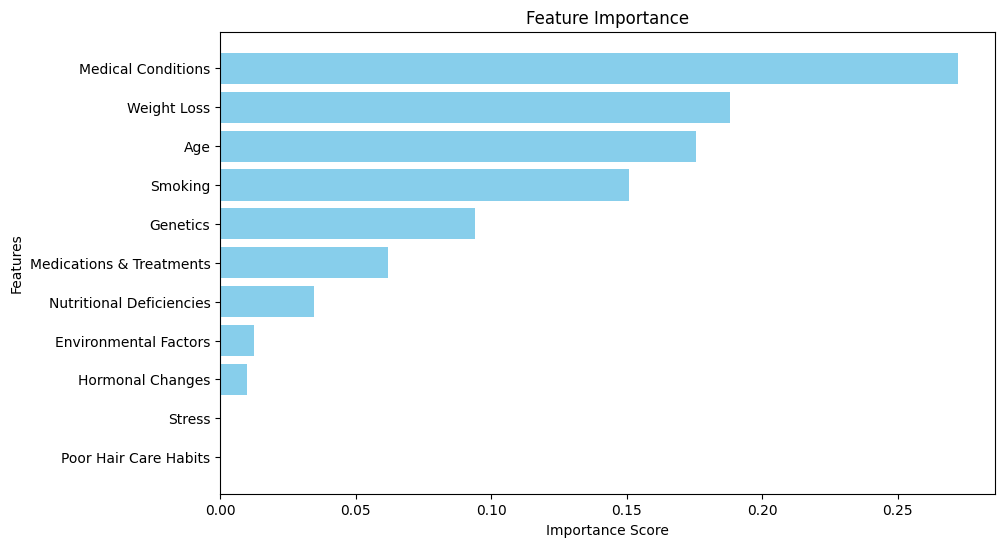

In [ ]:
# Get importance scores
importance = best_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
}).sort_values('Importance', ascending=False)

print(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()

In [ ]:
# Establishing accuracy baseline
# Most frequent class in training set is 'True'
# If we guess everything as 'True' in the test set, our accuracy is 48%
 
most_freq_class = y_train.value_counts().index[0]
print(f'Baseline Accuracy: {y_test.value_counts()[most_freq_class] / len(y_test):.2f}')

Baseline Accuracy: 0.46


In [ ]:
# Check Accuracy and Recall score

y_pred=best_model.predict(X_test)

print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred):.2f}")
print(f"Recall: {metrics.recall_score(y_test, y_pred):.2f}")

Accuracy: 0.50
Recall: 0.72


Our model performs slightly better than baseline.
With recall being 0.72, of the 116 cases with 'Hair Loss', we predicted 72% of them correctly on a completely unseen test set.
Our goal will be to minimise the remaining 28% with more data in the future.

Text(0.5, 1.0, 'Confusion Matrix')

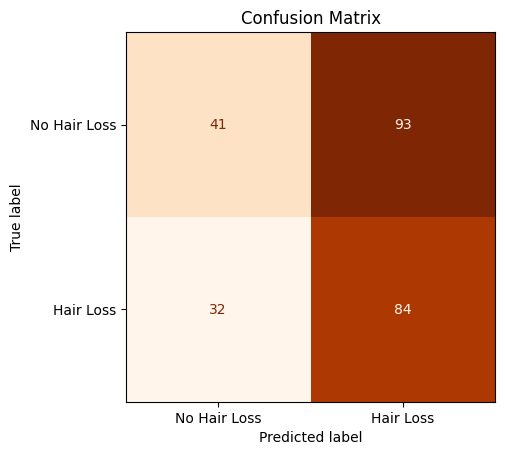

In [ ]:
disp = metrics.ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, display_labels=['No Hair Loss','Hair Loss'], cmap='Oranges', colorbar=False)
plt.title('Confusion Matrix')

Try plotting again with only top 5 features.

# Limitations

- No data about gender
- Advantages of Decision Tree:
    - Easy to understand and interpret: The tree structure makes it easy to visualize the decision-making process. 
    - Can handle both categorical and numerical data: Decision trees can be used with different types of data. 
    - Relatively fast to train: The algorithm is computationally efficient. 
- Disadvantages of Decision Tree:
    - Prone to overfitting: Decision trees can become too complex and learn the training data too well, leading to poor generalization on new data. 
    - Sensitive to small changes in the data: A small change in the training data can lead to a different decision tree. 
    - Can be unstable: Different decision trees can be created for the same dataset. 

- Difference between decision tree classifier and random forest classifier
    - Decision Tree is quick to process. Random Forest builds many individual decision trees and then averages the predictions (less susceptible to outliers)